In [4]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import *

import warnings
from tabulate import tabulate

In [5]:
SCRATCH = "/global/cscratch1/sd/qnicolas/"
def open_wrfds(path):
    ds = xr.open_mfdataset(path,combine='by_coords',use_cftime=True,concat_dim="Time")
    ds['time'] = (ds.indexes['time'].shift(2+(datetime.datetime(1970,1,1)-datetime.datetime(1,1,1)).days,'D')
                  ).to_datetimeindex()
    if 'pressure' in ds.coords:
        ds=ds.rename({'pressure':'level'})
    return ds

control_sfcvars = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.1000d/*.sfc.nc")
control_plvars  = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.1000d/*.pl.nc")
warm_sfcvars = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.SST2K_2XCO2.1000d/*.sfc.nc")
warm_plvars  = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.SST2K_2XCO2.1000d/*.pl.nc")

control_vars = xr.merge([control_plvars,control_sfcvars])
warm_vars = xr.merge([warm_plvars,warm_sfcvars])

#control_sfcvars = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.sfc.nc")
#control_plvars  = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.pl.nc")
#warm_sfcvars = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.SST2K.sfc.nc")
#warm_plvars  = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.SST2K.pl.nc")
#warm_co2_sfcvars = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.SST2K_2XCO2.sfc.nc")
#warm_co2_plvars  = open_wrfds(SCRATCH+"wrfdata/processed/wrf.mountain.100km.SST2K_2XCO2.pl.nc")


In [7]:
control_other = xr.open_mfdataset(SCRATCH+"wrfdata/saved/wrf.mountain.100km.1000d/*.nc_orig",combine='nested',use_cftime=True,concat_dim="Time")
warm_other = xr.open_mfdataset(SCRATCH+"wrfdata/saved/wrf.mountain.100km.SST2K_2XCO2.1000d/*.nc_orig",combine='nested',use_cftime=True,concat_dim="Time")

In [8]:
def scaling3(omega, temp, ps, levels):
    """Same as "scaling", but the arguments are sorted by increasing pressure and plevs are already input.
    scaling3 is to be vectorized by xarray"""
    
    return scaling(omega[::-1], temp[::-1], levels[::-1], ps)

def extreme_vars(pr,w,t,ps,quantile):
    quantile_inf = quantile-0.01
    quantile_sup = quantile+0.01
    pr2=pr.resample(time='6H').ffill()
    if quantile_sup<1:
        return (var.where((pr2 > pr2.chunk({'time': -1}).quantile(quantile_inf,"time")) &
                          (pr2 < pr2.chunk({'time': -1}).quantile(quantile_sup,"time"))
                          ,drop=True).mean('time',skipna=True).compute()  for var in (w,t,ps))
    else :
        return (var.where((pr2 > pr2.chunk({'time': -1}).quantile(quantile_inf,"time"))
                          ,drop=True).mean('time',skipna=True).compute()  for var in (w,t,ps))
        
def ogscaling(w,t,ps):
    ref_density = t.level*100/(287*t.mean(["west_east","south_north"]))
    pr = 86400*xr.apply_ufunc(scaling3,
                              -ref_density*9.81*w,
                              t,
                              100*ps,
                              100*w.level,
                              input_core_dims=[['level'], ['level'],[],['level']],vectorize=True,dask='parallelized',output_dtypes=[float]).compute()
    return pr
   

In [9]:
       
class WrfDataset :
    def __init__(self, ds,lbl):
        self.vars = ds#.chunk({'south_north': 2,'west_east': 2,'time':10})
        self.lbl = lbl
        self.precip_g_daily = 4*self.vars.precip_g.isel(time=range(200,len(self.vars.time))).diff('time').assign_coords(time = self.vars.precip_g.time.isel(time=range(200,len(self.vars.time)-1))).resample(time='1D').mean()
        self.precip_c_daily = 4*self.vars.precip_c.isel(time=range(200,len(self.vars.time))).diff('time').assign_coords(time = self.vars.precip_g.time.isel(time=range(200,len(self.vars.time)-1))).resample(time='1D').mean()
        self.precip_daily = self.precip_g_daily + self.precip_c_daily
        
    def set_orig_vars(self, ds):
        self.orig_vars = ds#.chunk({'south_north': 2,'west_east': 2,'Time':10})
    def set_evap(self):
        self.evap_tmean = self.orig_vars.QFX.isel(Time=range(200,len(self.orig_vars.Time))).mean("Time").compute()*86400

    def set_extreme_precip(self,quantile):
        self.ex_pr = self.precip_daily.chunk({'time': -1}).quantile(quantile,"time")
        self.ex_pr_zonmean = self.precip_daily.chunk({'time': -1}).quantile(quantile,"time").mean("west_east")
    def set_extreme_vars(self,quantile):
        self.ex_w,self.ex_t,self.ex_ps = extreme_vars(self.precip_daily,
                                                      self.vars.w_p,
                                                      self.vars.T_p,
                                                      self.vars.p_sfc,
                                                      quantile
                                                     )
    def compute_ogscaling(self):
        self.ex_pr_og=ogscaling(self.ex_w,self.ex_t,self.ex_ps)
            
    def set_extreme_precip_mountain(self,quantile):
        mountain_precip = self.precip_daily.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["south_north","west_east"])
        self.ex_pr_mountain = mountain_precip.chunk({'time': -1}).quantile(quantile,"time")
        self.ex_pr_mountain_all = mountain_precip.where(mountain_precip>self.ex_pr_mountain,drop=True)
    
    def set_extreme_vars_mountain(self,quantile):
        self.ex_w_mountain,self.ex_t_mountain,self.ex_ps_mountain = extreme_vars(self.precip_daily.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["south_north","west_east"]),
                                                                                 self.vars.w_p.isel(south_north=range(5),west_east=range(38,40)),
                                                                                 self.vars.T_p.isel(south_north=range(5),west_east=range(38,40)),
                                                                                 self.vars.p_sfc.isel(south_north=range(5),west_east=range(38,40)),
                                                                                 quantile
                                                                                )   
    def compute_ogscaling_mountain(self):
        self.ex_pr_mountain_og=ogscaling(self.ex_w_mountain,self.ex_t_mountain,self.ex_ps_mountain).mean(["west_east","south_north"])
    
    def compute_ogscaling_mountain_allevents(self):
        #compute 6-hourly times corresponding to extreme events
        ex_times = [pd.to_datetime(d+' {:0>2}'.format(h)) for d in list(pd.to_datetime(np.array(self.ex_pr_mountain_all.time)).strftime("%Y-%m-%d")) for h in range(0,24,6)]
        ex_w_mountain_all = self.vars.w_p.sel(time=ex_times).isel(south_north=range(5),west_east=range(38,40))
        ex_t_mountain_all = self.vars.T_p.sel(time=ex_times).isel(south_north=range(5),west_east=range(38,40))
        ex_ps_mountain_all = self.vars.p_sfc.sel(time=ex_times).isel(south_north=range(5),west_east=range(38,40))        
        self.ex_pr_mountain_og_all = ogscaling(ex_w_mountain_all,ex_t_mountain_all,ex_ps_mountain_all)
        self.ex_pr_mountain_og_all=self.ex_pr_mountain_og_all.resample(time='1D').mean(["time","west_east","south_north"]).sel(time=self.ex_pr_mountain_all.time)

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore",FutureWarning)
    control = WrfDataset(control_vars,"Control")
    warm = WrfDataset(warm_vars,"SST +2K, 2*CO2")

meanTinc=warm.vars.T_2m.mean(["time","west_east","south_north"])-control.vars.T_2m.mean(["time","west_east","south_north"])


In [7]:
t=time.time()
control.set_orig_vars(control_other)
warm.set_orig_vars(warm_other)
control.set_evap();warm.set_evap()
print(time.time()-t)


310.7048189640045


# Zonal-mean precip

Mean precip increase 6.78%/K


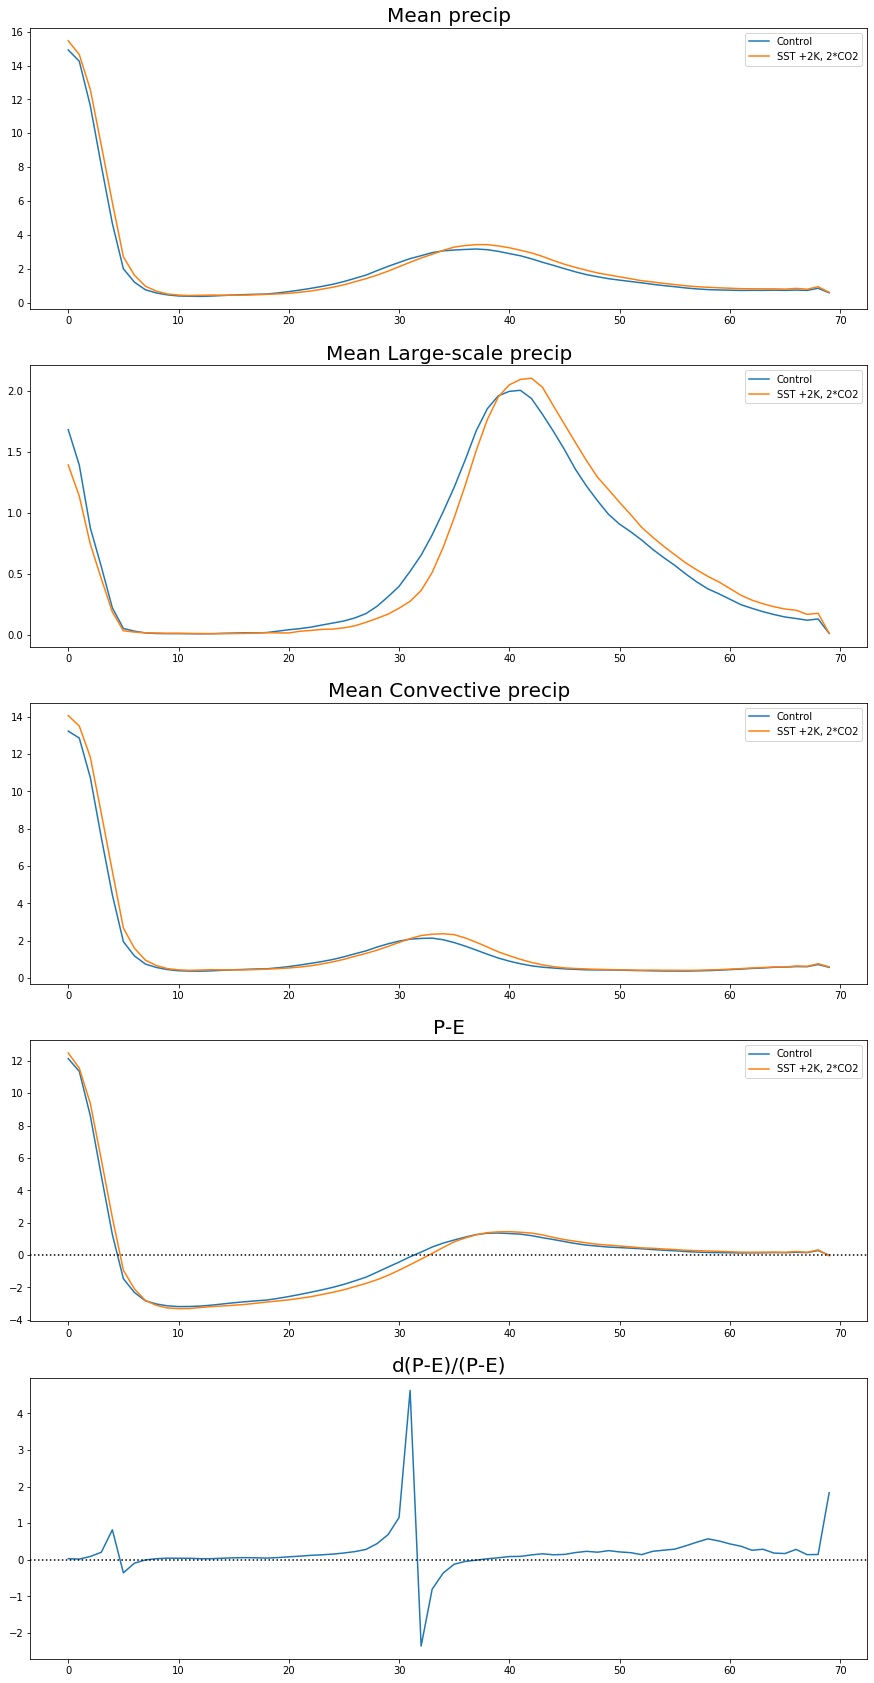

In [8]:
fig, ax = plt.subplots(5,1,figsize=(15,5*6))
for ds in [control,warm]:
    ax[0].plot(ds.vars.south_north,ds.precip_daily.mean(["time","west_east"]),label=ds.lbl)
    ax[1].plot(ds.vars.south_north,ds.precip_g_daily.mean(["time","west_east"]),label=ds.lbl)
    ax[2].plot(ds.vars.south_north,ds.precip_c_daily.mean(["time","west_east"]),label=ds.lbl)
    ax[3].plot(ds.vars.south_north,ds.precip_daily.mean(["time","west_east"])-ds.evap_tmean.mean("west_east"),label=ds.lbl)
ax[3].axhline(0.,linestyle=':',color='k')

pecont=control.precip_daily.mean(["time","west_east"])-control.evap_tmean.mean("west_east")
pewarm=warm.precip_daily.mean(["time","west_east"])-warm.evap_tmean.mean("west_east")

ax[4].plot(control.vars.south_north,(pewarm-pecont)/pecont)
ax[4].axhline(0.,linestyle=':',color='k')


ax[0].set_title("Mean precip",fontsize=20)
ax[1].set_title("Mean Large-scale precip",fontsize=20)
ax[2].set_title("Mean Convective precip",fontsize=20)
ax[3].set_title("P-E",fontsize=20)
ax[4].set_title("d(P-E)/(P-E)",fontsize=20)
for a in ax[:-1] :a.legend()
print("Mean precip increase %.2f%%/K"%(100*(warm.precip_daily.mean(["time","west_east","south_north"])-control.precip_daily.mean(["time","west_east","south_north"]))/control.precip_daily.mean(["time","west_east","south_north"])))

# Surface Temperature

Text(0.5, 0.98, 'T_2m, zonal average')

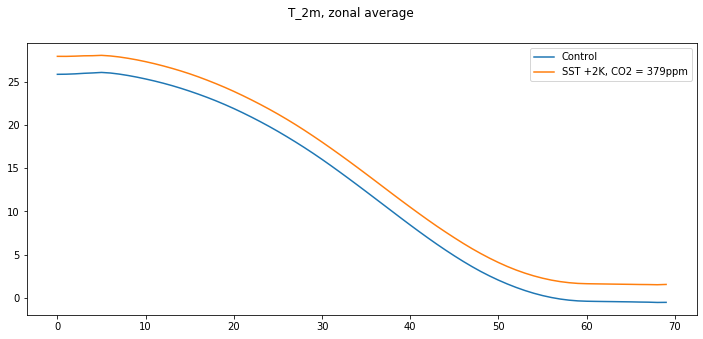

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i in range(len(t2s)):
    ax.plot(t2s[i].south_north,t2s[i].mean("west_east"),label=lbl[i])
#ax.plot(warm_SST.south_north,warm_SST-273.15,label="SST")
plt.legend()
fig.suptitle("T_2m, zonal average")

Text(0.5, 0.98, 'T_2m, at mountain longitude')

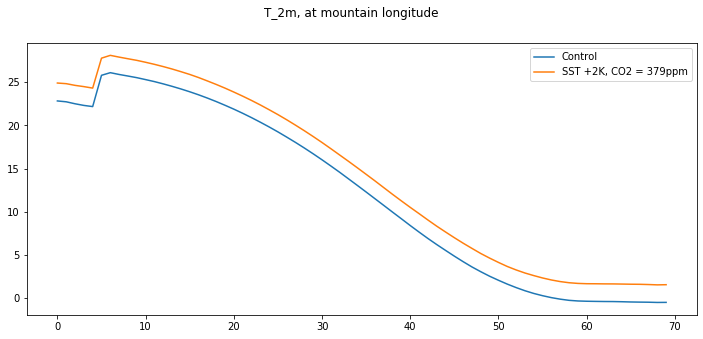

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i in range(len(t2s)):
    ax.plot(t2s[i].south_north,t2s[i].sel(west_east=slice(39,40)).mean("west_east"),label=lbl[i])
#ax.plot(warm_SST.south_north,warm_SST-273.15,label="SST")
plt.legend()
fig.suptitle("T_2m, at mountain longitude")

In [9]:
t=time.time()
al = xr.open_dataset(SCRATCH+"wrfdata/saved/wrf.mountain.100km.SST2K.long.nc_orig",use_cftime=True).isel(Time=range(200,1001))
print(time.time()-t)


0.2912113666534424


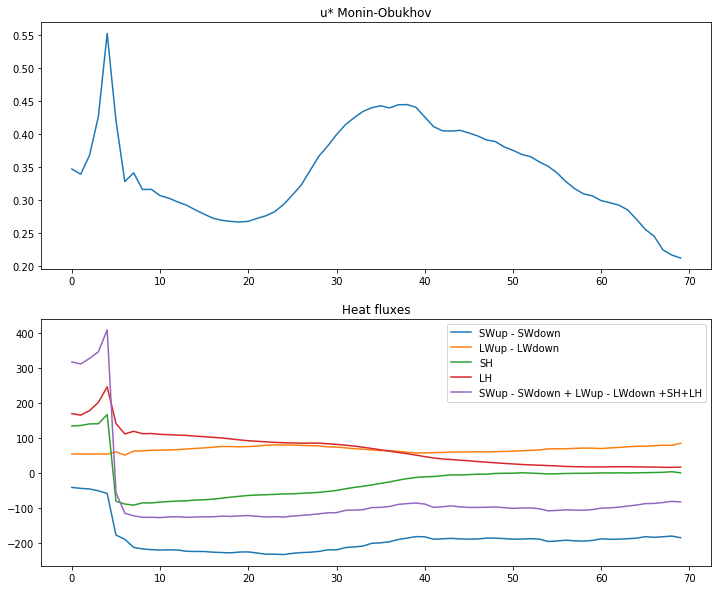

In [11]:
ust=al.UST
n=2
fig, ax = plt.subplots(n,1,figsize=(12,5*n))
ax[0].plot(ust.south_north,ust.sel(west_east=slice(39,40)).mean(["Time","west_east"]));ax[0].set_title("u* Monin-Obukhov")
fluxes = al.SWUPB-al.SWDNB
ax[1].plot(fluxes.south_north,fluxes.sel(west_east=slice(39,40)).mean(["Time","west_east"]),label="SWup - SWdown");
fluxes = al.LWUPB-al.LWDNB
ax[1].plot(fluxes.south_north,fluxes.sel(west_east=slice(39,40)).mean(["Time","west_east"]),label="LWup - LWdown");
fluxes = al.HFX-al.LH
ax[1].plot(fluxes.south_north,fluxes.sel(west_east=slice(39,40)).mean(["Time","west_east"]),label="SH");
fluxes = al.LH
ax[1].plot(fluxes.south_north,fluxes.sel(west_east=slice(39,40)).mean(["Time","west_east"]),label="LH");
fluxes = al.SWUPB-al.SWDNB+al.LWUPB-al.LWDNB+al.HFX
ax[1].plot(fluxes.south_north,fluxes.sel(west_east=slice(39,40)).mean(["Time","west_east"]),label="SWup - SWdown + LWup - LWdown +SH+LH");ax[1].set_title("Heat fluxes")
plt.legend()


# Precipitation extremes

In [218]:
print("%.2f mm/day"%(control.ex_pr.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"])))
print("%.2f mm/day"%(control.ex_pr_og.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"])))
print("")
print("%.2f mm/day"%(warm.ex_pr.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"])))
print("%.2f mm/day"%(warm.ex_pr_og.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"])))
print("")
print("%.2f mm/day"%(control.ex_pr_mountain))
print("%.2f mm/day"%(control.ex_pr_mountain_og))
print("")
print("%.2f mm/day"%(warm.ex_pr_mountain))
print("%.2f mm/day"%(warm.ex_pr_mountain_og))
print("")

155.15 mm/day
168.04 mm/day

179.68 mm/day
195.54 mm/day

102.67 mm/day
107.57 mm/day

114.62 mm/day
117.21 mm/day



In [11]:
pctile=95

t = time.time()
control.set_extreme_precip(pctile/100);warm.set_extreme_precip(pctile/100)
control.set_extreme_precip_mountain(pctile/100);warm.set_extreme_precip_mountain(pctile/100)
print(time.time()-t)

with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    warnings.simplefilter("ignore",FutureWarning)
    control.set_extreme_vars(pctile/100);warm.set_extreme_vars(pctile/100)
    print(time.time()-t)
    control.set_extreme_vars_mountain(pctile/100);warm.set_extreme_vars_mountain(pctile/100)
    print(time.time()-t)
    
    control.compute_ogscaling();warm.compute_ogscaling()
    control.compute_ogscaling_mountain();warm.compute_ogscaling_mountain()
    control.compute_ogscaling_mountain_allevents();warm.compute_ogscaling_mountain_allevents()
    print(time.time()-t)

12.174188375473022
176.81314992904663
207.7011797428131
226.00773286819458


In [12]:
import copy
pctile2=99
t = time.time()
control2 = copy.deepcopy(control)
warm2 = copy.deepcopy(warm)
print(time.time()-t)

control2.set_extreme_precip(pctile2/100);warm2.set_extreme_precip(pctile2/100)
control2.set_extreme_precip_mountain(pctile2/100);warm2.set_extreme_precip_mountain(pctile2/100)
print(time.time()-t)

with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    warnings.simplefilter("ignore",FutureWarning)
    control2.set_extreme_vars(pctile2/100);warm2.set_extreme_vars(pctile2/100)
    print(time.time()-t)
    control2.set_extreme_vars_mountain(pctile2/100);warm2.set_extreme_vars_mountain(pctile2/100)
    print(time.time()-t)
    
    control2.compute_ogscaling();warm2.compute_ogscaling()
    control2.compute_ogscaling_mountain();warm2.compute_ogscaling_mountain()
    control2.compute_ogscaling_mountain_allevents();warm2.compute_ogscaling_mountain_allevents()
    print(time.time()-t)

0.03562498092651367
4.137650012969971
48.18651366233826
77.59610104560852
92.91130256652832


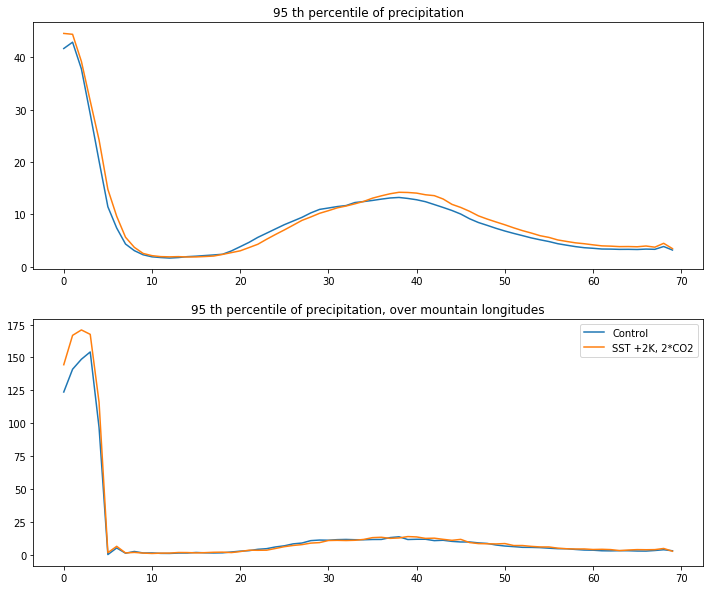

In [10]:
fig, ax = plt.subplots(2,1,figsize=(12,10))

for ds in [control,warm]:
    ax[0].plot(ds.vars.south_north,ds.ex_pr_zonmean,label=ds.lbl)
    ax[0].set_title("%i th percentile of precipitation"%pctile)
    ax[1].plot(ds.vars.south_north,ds.ex_pr.sel(west_east=slice(38,40)).mean("west_east"),label=ds.lbl)
    ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

## Vertical motion profiles over tropics/mountains on precip extremes days

121.91894006729126
164.5335729122162


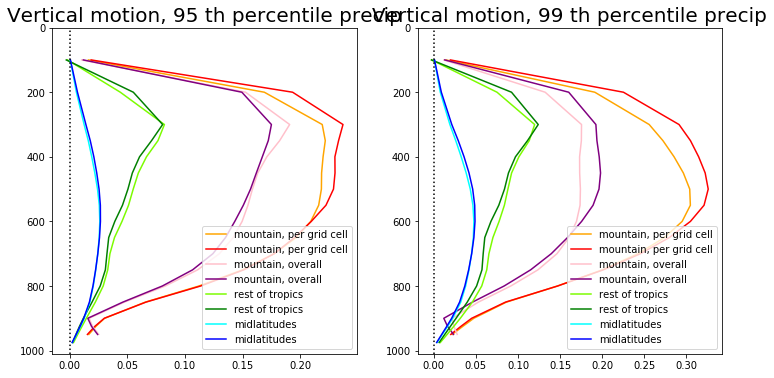

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

def plot_w(ax,control,warm,pctile):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=RuntimeWarning)
        ax.plot(control.ex_w.isel(south_north=range(5),west_east=range(38,40)).mean(["south_north","west_east"]),control.ex_w.level,label="mountain, per grid cell",color="orange")
        ax.plot(   warm.ex_w.isel(south_north=range(5),west_east=range(38,40)).mean(["south_north","west_east"]),warm.ex_w.level,label="mountain, per grid cell",color="red")
        
        ax.plot(control.ex_w_mountain.mean(["south_north","west_east"]),control.ex_w_mountain.level,label="mountain, overall",color="pink")
        ax.plot(   warm.ex_w_mountain.mean(["south_north","west_east"]),warm.ex_w_mountain.level,label="mountain, overall",color="purple")
            
        ax.plot(control.ex_w.isel(south_north=range(5)).sel(west_east=((control.ex_w.west_east<20)|(control.ex_w.west_east>60))).mean(["south_north","west_east"]),control.ex_w.level,label="rest of tropics",color="lawngreen")
        ax.plot(   warm.ex_w.isel(south_north=range(5)).sel(west_east=((warm.ex_w.west_east<20)|(warm.ex_w.west_east>60))).mean(["south_north","west_east"]),warm.ex_w.level,label="rest of tropics",color="green")
    
        ax.plot(control.ex_w.isel(south_north=range(40,60)).mean(["south_north","west_east"]),control.ex_w.level,label="midlatitudes",color="cyan")
        ax.plot(   warm.ex_w.isel(south_north=range(40,60)).mean(["south_north","west_east"]),warm.ex_w.level,label="midlatitudes",color="blue")
        
    ax.axvline(0,linestyle=':',color='k')
    
    ax.set_title("Vertical motion, %i th percentile precip"%pctile,fontsize=20)
    ax.legend(loc='lower right')
    ax.set_ylim(1010,0)
    
plot_w(ax[0],control,warm,pctile)
plot_w(ax[1],control2,warm2,pctile2)

## Extreme precipitation sensitivity

Text(0.5, 0.98, 'Sensitivity of the 95 th pctile of precip, %/(K of global mean temperature)')

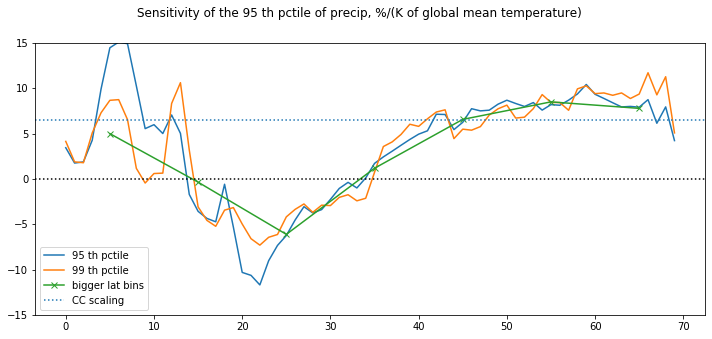

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(control.vars.south_north,100*(warm.ex_pr_zonmean-control.ex_pr_zonmean)/control.ex_pr_zonmean/meanTinc, label = "%i th pctile"%pctile)
ax.plot(control2.vars.south_north,100*(warm2.ex_pr_zonmean-control2.ex_pr_zonmean)/control2.ex_pr_zonmean/meanTinc, label = "%i th pctile"%pctile2)


with warnings.catch_warnings():
    warnings.simplefilter("ignore",category=FutureWarning)       
    resample_factor=10
    resampled_pr95_warm    =    warm.ex_pr.groupby(((   warm.vars.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
    resampled_pr95_control = control.ex_pr.groupby(((control.vars.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
ax.plot(resampled_pr95_warm.south_north,100*(resampled_pr95_warm-resampled_pr95_control)/resampled_pr95_control/meanTinc,'-x',label="bigger lat bins")

ax.axhline(6.5,linestyle=":",label="CC scaling")
ax.axhline(0.,linestyle=":",color="k")

ax.set_ylim(-15,15)

plt.legend()
fig.suptitle("Sensitivity of the %i th pctile of precip, %%/(K of global mean temperature)"%pctile)

In [13]:
def print_sensitivities(control,warm,pctile):
    print("%i th percentile"%pctile)
    print("Sensitivity over tropics (0-20° lat): %.2f%%"%(
        100*(   warm.ex_pr_zonmean.sel(south_north=slice(0,19)).mean("south_north")
            -control.ex_pr_zonmean.sel(south_north=slice(0,19)).mean("south_north"))
            /control.ex_pr_zonmean.sel(south_north=slice(0,19)).mean("south_north")
            /meanTinc
            ))
    
    print("Sensitivity over mountain: %.2f%%"%(
        100*(   warm.ex_pr.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"])
            -control.ex_pr.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"]))
            /control.ex_pr.sel(south_north=slice(0,5),west_east=slice(38,40)).mean(["west_east","south_north"])
            /meanTinc
            ))
    
    print("Sensitivity over subtropics (20-40° lat): %.2f%%"%(
        100*(   warm.ex_pr_zonmean.sel(south_north=slice(20,39)).mean("south_north")
            -control.ex_pr_zonmean.sel(south_north=slice(20,39)).mean("south_north"))
            /control.ex_pr_zonmean.sel(south_north=slice(20,39)).mean("south_north")
            /meanTinc
            ))
    
    print("Sensitivity over Midlatitudes (40-70° lat): %.2f%%"%(
        100*(   warm.ex_pr_zonmean.sel(south_north=slice(40,70)).mean("south_north")
            -control.ex_pr_zonmean.sel(south_north=slice(40,70)).mean("south_north"))
            /control.ex_pr_zonmean.sel(south_north=slice(40,70)).mean("south_north")
            /meanTinc
            ))

print_sensitivities(control,warm,pctile)
print_sensitivities(control2,warm2,pctile2)

95 th percentile
Sensitivity over tropics (0-20° lat): 4.63%
Sensitivity over mountain: 7.58%
Sensitivity over subtropics (20-40° lat): -1.99%
Sensitivity over Midlatitudes (40-70° lat): 7.31%
99 th percentile
Sensitivity over tropics (0-20° lat): 3.28%
Sensitivity over mountain: 7.74%
Sensitivity over subtropics (20-40° lat): -1.97%
Sensitivity over Midlatitudes (40-70° lat): 7.40%


## Extreme events over the mountain

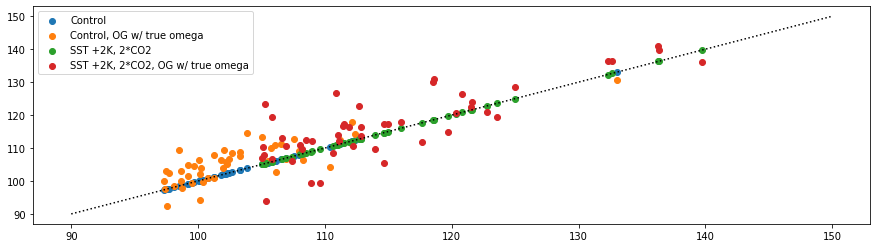

In [30]:
_,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot([90,150],[90,150],':k')#,color="lightgrey")
for ds in [control,warm] :
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_all,label=ds.lbl)
    #ax.scatter(p95,precip_g_mountain_p95 ,label="large-scale precip")
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_og_all,label=ds.lbl+", OG w/ true omega")
    #ax.scatter(p95,pr_og_sin_p95_mountain,label="OG w/ u.grad(h), 1st baroclinic mode profile")
    #ax.scatter(p95,pr_roe_mountain_p95   ,label="Roe")
    ax.legend()

precip efficiency, Control : 0.98
precip efficiency, SST +2K, 2*CO2 : 0.98


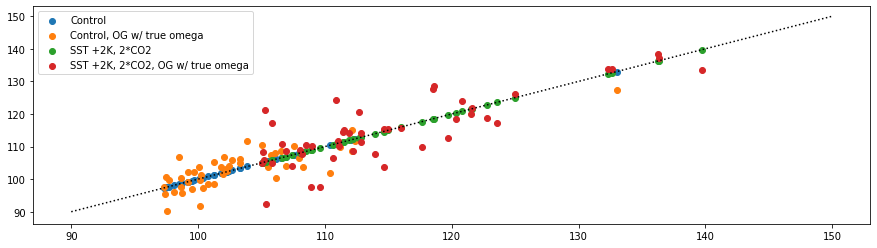

In [31]:
_,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot([90,150],[90,150],':k')#,color="lightgrey")
for ds in [control,warm] :
    pr_eff = np.mean(np.array(ds.ex_pr_mountain_og_all))/np.mean(np.array(ds.ex_pr_mountain_all))
    print('precip efficiency, %s : %.2f'%(ds.lbl,1/pr_eff))
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_all,label=ds.lbl)
    #ax.scatter(p95,precip_g_mountain_p95 ,label="large-scale precip")
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_og_all/pr_eff,label=ds.lbl+", OG w/ true omega")
    #ax.scatter(p95,pr_og_sin_p95_mountain,label="OG w/ u.grad(h), 1st baroclinic mode profile")
    #ax.scatter(p95,pr_roe_mountain_p95   ,label="Roe")
    ax.legend()

## Sensitivity breakdown (Fildier et al 2017)

In [13]:
def dqsat_dp(temp, plev, ps):
    temp = temp[::-1]
    plev = plev[::-1]
    try:
        if plev[0]<plev[1]:
            print(plev)
            raise ValueError('unexpected ordering of pressure levels')
    except ValueError:
        raise
        
    # criterion for identifying tropopause
    crit_lapse_rate = 0.002 # (k/m) for tropopause
    plev_mask = 0.05e5 # (Pa) exclude levels above this as a fail-safe

    dqsat_dp, dqsat_dT,_ = sat_deriv(plev, temp)
    es, qsat, rsat, latent_heat = saturation_thermodynamics(temp, plev, 'era')
    lapse_rate = moist_adiabatic_lapse_rate(temp, plev, 'era')

    # virtual temperature
    temp_virtual = temp*(1.0+qsat*(pars('gas_constant_v')/pars('gas_constant')-1.0))

    # density
    rho = plev/pars('gas_constant')/temp_virtual

    dT_dp = lapse_rate/pars('gravity')/rho

    # find derivative of saturation specific humidity with respect to pressure along 
    # a moist adiabat at the given temperature and pressure for each level
    dqsat_dp_total = dqsat_dp+dqsat_dT*dT_dp

    # mask above tropopause using simple lapse rate criterion
    dT_dp_env = np.gradient(temp, plev)
    lapse_rate_env = dT_dp_env*rho*pars('gravity')

    itrop = np.where(lapse_rate_env>crit_lapse_rate)[0]
    if itrop.size!=0:
        if np.max(itrop)+1<len(plev):
            dqsat_dp_total[np.max(itrop)+1:]=0

    # mask above certain level as fail safe
    dqsat_dp_total[plev<plev_mask]=0
    return dqsat_dp_total[::-1]

def vinteg(ds):
    return xr.apply_ufunc(integrate,
                          ds.fillna(0.),
                          ds.level,
                          input_core_dims=[['level'], ['level']],vectorize=True,dask='parallelized',output_dtypes=[float]).compute()

def PR(control,warm,DeltaT):
    return (warm.ex_pr /control.ex_pr -1.)/DeltaT

def PR_mountain(control,warm,DeltaT):
    return (warm.ex_pr_mountain /control.ex_pr_mountain -1.)/DeltaT

def E(control,warm,DeltaT):
    return ((warm.ex_pr/warm.ex_pr_og)/(control.ex_pr/control.ex_pr_og) -1.)/DeltaT

def E_mountain(control,warm,DeltaT):
    return ((warm.ex_pr_mountain/warm.ex_pr_mountain_og)/(control.ex_pr_mountain/control.ex_pr_mountain_og) -1.)/DeltaT

def D1(control,warm,DeltaT):
    return (vinteg(warm.ex_w) / vinteg(control.ex_w) -1.)/DeltaT

def D1_mountain(control,warm,DeltaT):
    return (vinteg(   warm.ex_w_mountain).mean(['west_east','south_north'])
            /vinteg(control.ex_w_mountain).mean(['west_east','south_north']) -1.)/DeltaT


def gamma(t,ps):
    return xr.apply_ufunc(dqsat_dp,
                          t,
                          t.level*100.,
                          ps,
                          input_core_dims=[['level'], ['level'], []],output_core_dims=[['level']],vectorize=True,dask='parallelized',output_dtypes=[float]).compute()
def mu(w,t):
    ref_density = t.level*100/(287*t.mean(["west_east","south_north"]))
    return -ref_density*9.81*w / vinteg(-ref_density*9.81*w)
    
def D2(control,warm,DeltaT):
    control_gamma = gamma(control.ex_t,control.ex_ps)
    warm_gamma    = gamma(   warm.ex_t,   warm.ex_ps)
    control_mu = mu(control.ex_w,control.ex_t)
    warm_mu    = mu(   warm.ex_w,   warm.ex_t)
    return (vinteg(control_gamma*(warm_mu-control_mu))
            /vinteg(control_gamma*control_mu)            
           )/DeltaT

def D2_mountain(control,warm,DeltaT):
    control_gamma = gamma(control.ex_t_mountain,control.ex_ps_mountain)
    warm_gamma    = gamma(   warm.ex_t_mountain,   warm.ex_ps_mountain)
    control_mu = mu(control.ex_w_mountain,control.ex_t_mountain)
    warm_mu    = mu(   warm.ex_w_mountain,   warm.ex_t_mountain)
    return (vinteg(control_gamma*(warm_mu-control_mu)).mean(['west_east','south_north'])
           /vinteg(control_gamma*control_mu).mean(['west_east','south_north'])
           /DeltaT)

def T(control,warm,DeltaT):
    control_gamma = gamma(control.ex_t,control.ex_ps)
    warm_gamma    = gamma(   warm.ex_t,   warm.ex_ps)
    control_mu = mu(control.ex_w,control.ex_t)
    warm_mu    = mu(   warm.ex_w,   warm.ex_t)
    return (vinteg(control_mu*(warm_gamma-control_gamma))
            /vinteg(control_gamma*control_mu)            
           )/DeltaT


def T_mountain(control,warm,DeltaT):
    control_gamma = gamma(control.ex_t_mountain,control.ex_ps_mountain)
    warm_gamma    = gamma(   warm.ex_t_mountain,   warm.ex_ps_mountain)
    control_mu = mu(control.ex_w_mountain,control.ex_t_mountain)
    warm_mu    = mu(   warm.ex_w_mountain,   warm.ex_t_mountain)
    return (vinteg(control_mu*(warm_gamma-control_gamma)).mean(['west_east','south_north'])
           /vinteg(control_gamma*control_mu).mean(['west_east','south_north'])
           /DeltaT)


In [37]:
tropics_limit=5

def mean_mountain(x):
    return x.isel(south_north=range(5),west_east=range(38,40)).mean(['west_east','south_north'])
def mean_tropics(x):
    return x.isel(south_north=range(tropics_limit)).sel(west_east=((x.west_east<20)|(x.west_east>60))).mean(['west_east','south_north'])
def mean_subtropics(x):
    return x.isel(south_north=range(20,30)).mean(['west_east','south_north'])
def mean_midlatitudes(x):
    return x.isel(south_north=range(40,60)).mean(['west_east','south_north'])

def sensitivity_breakdown(control,warm,pctile):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=RuntimeWarning)
                      
        prsens   = PR(control,warm,meanTinc)
        prsensm  = mean_mountain(prsens)
        prsenst  = mean_tropics(prsens)
        prsenss  = mean_subtropics(prsens)
        prsense  = mean_midlatitudes(prsens)
        prsensm2 = PR_mountain(control,warm,meanTinc)
        
        e   = E(control,warm,meanTinc)
        em  = mean_mountain(e)
        et  = mean_tropics(e)
        es  = mean_subtropics(e)
        ee  = mean_midlatitudes(e)
        em2 = E_mountain(control,warm,meanTinc)
        
        d1   = D1(control,warm,meanTinc)
        d1m  = mean_mountain(d1)
        d1t  = mean_tropics(d1)
        d1s  = mean_subtropics(d1)
        d1e  = mean_midlatitudes(d1)
        d1m2 = D1_mountain(control,warm,meanTinc)
        
        d2   = D2(control,warm,meanTinc)
        d2m  = mean_mountain(d2)
        d2t  = mean_tropics(d2)
        d2s  = mean_subtropics(d2)
        d2e  = mean_midlatitudes(d2)
        d2m2 = D2_mountain(control,warm,meanTinc)
        
        th   = T(control,warm,meanTinc)
        thm  = mean_mountain(th)
        tht  = mean_tropics(th)
        ths  = mean_subtropics(th)
        the  = mean_midlatitudes(th)
        thm2 = T_mountain(control,warm,meanTinc)
        
    print(' '*30+'\033[1m'+ "Extreme precip sensitivity breakdown, %i th percentile"%pctile + '\033[0m')
    
    tab=[['Mountain - Computed per grid cell, then averaged' ,"%.2f"%(100*prsensm),"%.2f"%(100*em),"%.2f"%(100*d1m),"%.2f"%(100*d2m),"%.2f"%(100*thm),"%.2f"%(100*(prsensm-em-d1m-d2m-thm))],
         ['Mountain - Averaged over grid cells then computed',"%.2f"%(100*prsensm2),"%.2f"%(100*em2),"%.2f"%(100*d1m2),"%.2f"%(100*d2m2),"%.2f"%(100*thm2),"%.2f"%(100*(prsensm2-em2-d1m2-d2m2-thm2))],
         ['Rest of the tropics - 0°-%i°'%tropics_limit ,"%.2f"%(100*prsenst),"%.2f"%(100*et),"%.2f"%(100*d1t),"%.2f"%(100*d2t),"%.2f"%(100*tht),"%.2f"%(100*(prsenst-et-d1t-d2t-tht))],
         ['Subtropics - 20°-30°' ,"%.2f"%(100*prsenss),"%.2f"%(100*es),"%.2f"%(100*d1s),"%.2f"%(100*d2s),"%.2f"%(100*ths),"%.2f"%(100*(prsenss-es-d1s-d2s-ths))],
         ['Midlatitudes - 40°-60°' ,"%.2f"%(100*prsense),"%.2f"%(100*ee),"%.2f"%(100*d1e),"%.2f"%(100*d2e),"%.2f"%(100*the),"%.2f"%(100*(prsense-ee-d1e-d2e-the))],
        ]
    
    print(tabulate(tab, headers=['Region', 'Precip (%)', 'Efficiency (%)', 'D1 (%)', 'D2 (%)', 'T (%)', 'N (%)']))


In [38]:
t=time.time()
sensitivity_breakdown(control,warm,pctile)
sensitivity_breakdown(control2,warm2,pctile2)
print(time.time()-t)
    

Region                                               Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
-------------------------------------------------  ------------  ----------------  --------  --------  -------  -------
Mountain - Computed per grid cell, then averaged           8.58              1.42      2.85     -0.73     6.01    -0.97
Mountain - Averaged over grid cells then computed          4.16              0.19     -1.82     -0.21     7.14    -1.14
Rest of the tropics - 0°-5°                                2.78              1.81     -0.85     -1.54     6.3     -2.96
Subtropics - 20°-30°                                      -6.52              5.25    -12.47      2.33     5.39    -7.02
Midlatitudes - 40°-60°                                     8.04              0.81      2.43     -0.92     7.4     -1.69
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                                               Precip (%)    Efficien